In [61]:

# Written by Hippolyte Bourel.
# This code is proposed as a reference solution for various exercises of Home Assignements for the OReL course in 2024.
# This solution is tailored for simplicity of understanding and is in no way optimal, nor the only way to implement the different elements!
import numpy as np


# A simple 4-room gridworld implementation with a grid of 7x7 for a total of 20 states (the walls do not count!).
# We arbitrarily chose the actions '0' = 'go up', '1' = 'go right', '2'  = 'go down' thus '3' = 'go left'
# Finally the state '0' is the top-left corner, 'nS - 1' is the down-right corner.
# The agent is unable to leave the state '19' (down-right corner) and receive a reward of 1 for all actions in this state.
class Four_Room():
    def __init__(self, teleport = False):
        self.nS = 20
        nS = self.nS
        self.nA = 4

        self.map = [[-1, -1, -1, -1, -1, -1, -1],
                    [-1,  0,  1,  2,  3,  4, -1],
                    [-1,  5,  6, -1,  7,  8, -1],
                    [-1,  9, -1, -1, 10, -1, -1],
                    [-1, 11, 12, 13, 14, 15, -1],
                    [-1, 16, 17, -1, 18, 19, -1],
                    [-1, -1, -1, -1, -1, -1, -1]]
        map = np.array(self.map)

        # We build the transitions matrix P using the map.
        self.P = np.zeros((nS, 4, nS))

        for s in range(nS):
            temp = np.where(s == map)
            y, x = temp[0][0], temp[1][0]
            up = map[x, y-1]
            right = map[x+1, y]
            down = map[x, y+1]
            left = map[x-1, y]

            # Action 0: go up.
            self._init_up(s, up, right, down, left)			
            
            # Action 1: go right.
            self._init_right(s, up, right, down, left)
            
            # Action 2: go down.
            self._init_down(s, up, right, down, left)

            # Action 3: go left.
            self._init_left(s, up, right, down, left)
            
            # Set to teleport back when in the rewarding state.
            if s == self.nS - 1:
                for a in range(4):
                    if teleport:
                        # Set the transition probability for the rewarding state to 0
                        self.P[s, a, s] = 0
                        # Set the transition probabilities for all other states
                        self.P[s, a, :s] = 1 / (self.nS - 1)
                        self.P[s, a, s+1:] = 1 / (self.nS - 1)
                    else:
                        # Set all probabilities to 0
                        self.P[s, a, :] = 0
                        # Set the transition probability for the rewarding state to 1
                        self.P[s, a, s] = 1

                        
                        

            
        # We build the reward matrix R.
        self.R = np.zeros((nS, 4))
        for a in range(4):
            self.R[nS - 1, a] = 1

        # We (arbitrarily) set the initial state in the top-left corner.
        self.s = 0
        
    def _init_right(self, s, up, right, down, left):
        a = 1
        self.P[s, a, s] += 0.1
        # Up
        if up == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, up] += 0.1
        # Right
        if right == -1:
            self.P[s, a, s] += 0.7
        else:
            self.P[s, a, right] += 0.7
        # Down
        if down == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, down] += 0.1

    def _init_up(self, s, up, right, down, left):
        """
        Initialize the transition matrix for the action 'up' in the state 's'.
        """
        a = 0
        self.P[s, a, s] += 0.1
        # Up
        if up == -1:
            self.P[s, a, s] += 0.7
        else:
            self.P[s, a, up] += 0.7
        # Right
        if right == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, right] += 0.1
        # Left
        if left == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, left] += 0.1

    def _init_down(self, s, up, right, down, left):
        a = 2
        self.P[s, a, s] += 0.1
        # Right
        if right == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, right] += 0.1
        # Down
        if down == -1:
            self.P[s, a, s] += 0.7
        else:
            self.P[s, a, down] += 0.7
        # Left
        if left == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, left] += 0.1

    def _init_left(self, s, up, right, down, left):
        a = 3
        self.P[s, a, s] += 0.1
        # Up
        if up == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, up] += 0.1
        # Down
        if down == -1:
            self.P[s, a, s] += 0.1
        else:
            self.P[s, a, down] += 0.1
        # Left
        if left == -1:
            self.P[s, a, s] += 0.7
        else:
            self.P[s, a, left] += 0.7

    # To reset the environment in initial settings.
    def reset(self):
        self.s = 0
        return self.s

    # Perform a step in the environment for a given action. Return a couple state, reward (s_t, r_t).
    def step(self, action):
        new_s = np.random.choice(np.arange(self.nS), p=self.P[self.s, action])
        reward = self.R[self.s, action]
        self.s = new_s
        return new_s, reward


def VI(env, gamma=0.98, epsilon=1e-10):
    """
    Value Iteration algorithm.
    
    :param env: Four_Room instance.
    :param gamma: Discount factor.
    :param epsilon: Threshold for a stopping criterion.
    :return: Number of iterations, optimal policy, and value function.
    """

    # Initialization of the value function to zeros.
    V0 = np.zeros(env.nS)
    Rmax = np.max(env.R)
    V1 = np.full(env.nS, Rmax / (1 - gamma))
    
    niter = 0  # Iteration counter.

    # The main loop of the VI algorithm.
    while True:
        niter += 1
        V0 = V1.copy()  # Update the previous value function.

        # Update the value function for each state.
        for s in range(env.nS):
            V1[s] = max([env.R[s, a] + gamma * sum([p * V0[ss] for (ss, p) in enumerate(env.P[s, a])]) for a in range(env.nA)])

        # Check for convergence.
        if np.max(np.abs(V1 - V0)) < epsilon * (1 - gamma) / (2 * gamma):
            break

    # Once we have the optimal value function, derive the optimal policy.
    optimal_policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        action_values = []
        for a in range(env.nA):
            action_value = env.R[s, a] + gamma * sum([p * V0[ss] for (ss, p) in enumerate(env.P[s, a])])
            action_values.append(action_value)
        optimal_policy[s] = np.argmax(action_values)

    return niter, optimal_policy, V1


# An implementation of the PI algorithm, using a matrix inversion to do the policy evaluation step.
# Return the number of iterations and the policy.
def PI(env, gamma = 0.98):

    # Initialisation of the variables.
    policy0 = np.random.randint(env.nA, size = env.nS)
    policy1 = np.zeros(env.nS, dtype = int)
    niter = 0

    # The main loop of the PI algorithm.
    while True:
        niter += 1

        # Policy evaluation step.
        P_pi = np.array([[env.P[s, policy0[s], ss] for ss in range(env.nS)] for s in range(env.nS)])
        R_pi = np.array([env.R[s, policy0[s]] for s in range(env.nS)])
        V0 = np.linalg.inv((np.eye(env.nS) - gamma * P_pi)) @ R_pi
        V1 = np.zeros(env.nS)

        # Updating the policy.
        for s in range(env.nS):
            for a in range(env.nA):
                temp = env.R[s, a] + gamma * sum([u * p for (u, p) in zip(V0, env.P[s, a])])
                if (a == 0) or (temp > V1[s]):
                    V1[s] = temp
                    policy1[s] = a

        # Testing if the policy changed or not.
        test = True
        for s in range(env.nS):
            if policy0[s] != policy1[s]:
                test = False
                break
        
        Vdiff = [V1[i] - V0[i] for i in range(env.nS)]

        # If the policy did not change or the change was due to machine limitation in numerical values return the result.	
        if test or (max(Vdiff) < 10**(-12)):
            return niter, policy1, V0
        else:
            policy2 = policy0
            policy0 = policy1
            policy1 = np.zeros(env.nS, dtype=int)



# A naive function to output a readble matrix from a policy on the 4-room environment.
def display_4room_policy(policy, env, use_arrows=True):
    map = env.map
    arrow_map = {0: '↑    ', 1: '→    ', 2: '↓    ', 3: '←    '}
    res = []

    for i in range(7):
        temp = []
        for j in range(7):
            if map[i][j] == -1:
                temp.append("Wall ")
            elif policy[map[i][j]] == 0:
                temp.append(arrow_map[0] if use_arrows else " Up  ")
            elif policy[map[i][j]] == 1:
                temp.append(arrow_map[1] if use_arrows else "Right")
            elif policy[map[i][j]] == 2:
                temp.append(arrow_map[2] if use_arrows else "Down ")
            elif policy[map[i][j]] == 3:
                temp.append(arrow_map[3] if use_arrows else "Left ")
        
        res.append(temp)

    return np.array(res)


In [62]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

def plot_policy_and_value(env, pi, v_star, fig_name=None):
    # Initialize a 7x7 grid
    grid = np.full((7, 7), np.nan)  # Use NaN for non-assigned cells

    # Map v_star to the grid, skipping walls
    v_star_index = 0
    for i in range(7):
        for j in range(7):
            if env[i][j] != -1:
                grid[i][j] = v_star[v_star_index]
                v_star_index += 1

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 7))

    # Normalize the colormap to the range of v_star values
    norm = Normalize(vmin=min(v_star), vmax=max(v_star))

    # Display the grid as a heatmap
    cmap = plt.cm.viridis  # Heatmap colormap
    cmap.set_bad('black')  # Set color for NaN (walls) to black
    heatmap = ax.imshow(grid, cmap=cmap, norm=norm)

    # Add a color bar
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Value', rotation=270, labelpad=20)

    # Overlay arrows for policy
    for i, row in enumerate(env):
        for j, state in enumerate(row):
            if state == -1:
                continue
            
            if env[i][j] == 19:
                continue
            
            action = pi[state]
            dx, dy = 0, 0
            if action == 0:  # up
                dy = -0.5
            elif action == 1:  # right
                dx = 0.5
            elif action == 2:  # down
                dy = 0.5
            elif action == 3:  # left
                dx = -0.5
            ax.arrow(j - 0.5 * dx, i - 0.5 * dy, dx, dy, head_width=0.2, head_length=0.2, fc='white', ec='white')

    # Adjust plot
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_aspect('equal')
    if fig_name is not None:
        plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

# 2 (i)

Number of iterations for PI:  6


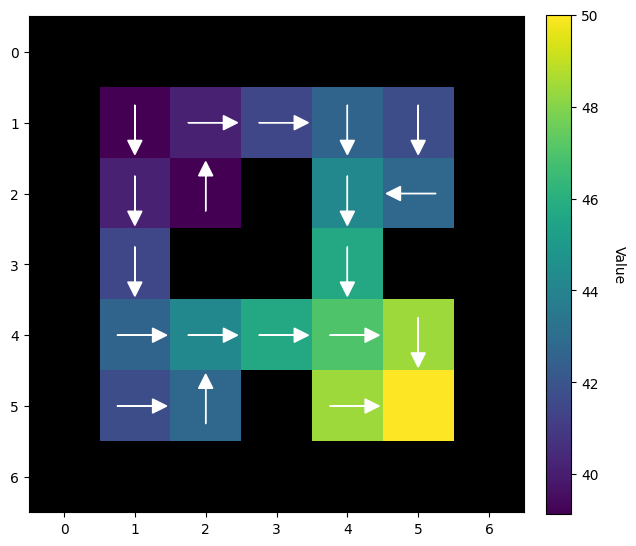

In [63]:
env = Four_Room()
niter, pi, v_star = PI(env, 0.98)
print("Number of iterations for PI: ", niter + 1)
plot_policy_and_value(env.map, pi, v_star, fig_name="artifacts/2_i.png")

# 2 (ii)

Number of iterations for VI:  50


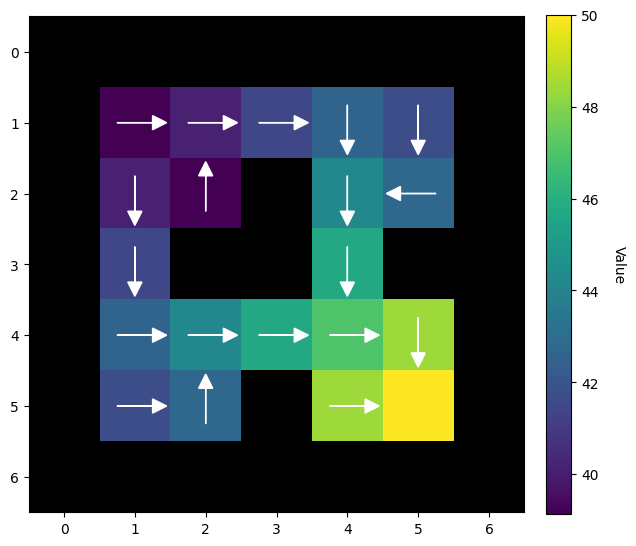

In [64]:
env = Four_Room()
niter, vi, v_star = VI(env, 0.98, 10**(-6))
print("Number of iterations for VI: ", niter + 1)
plot_policy_and_value(env.map, vi, v_star, fig_name="artifacts/2_ii.png")

# 2 (iii)

Number of iterations for VI:  906


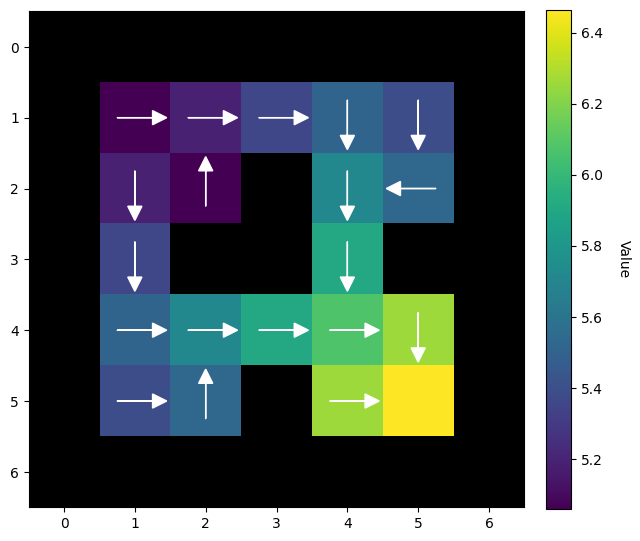

In [65]:
env = Four_Room(teleport=True)
niter, vi, v_star = VI(env, 0.98, 10**(-6))
print("Number of iterations for VI: ", niter)
plot_policy_and_value(env.map, vi, v_star, fig_name="artifacts/2_iii.png")

# 2 (iv)

Number of iterations for VI:  3927


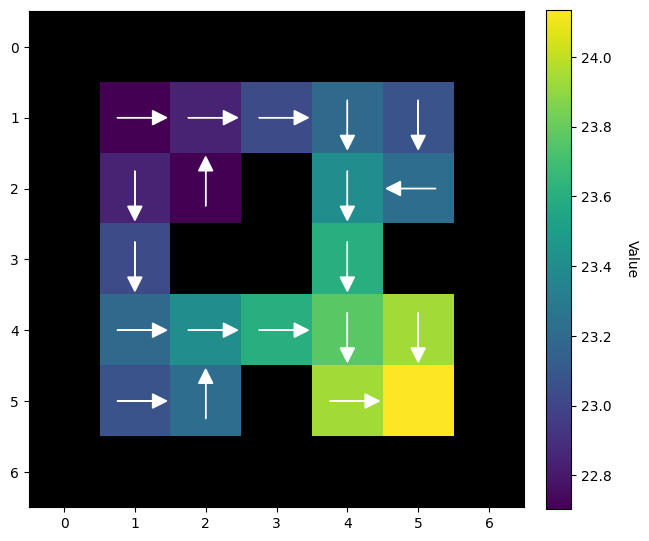

In [60]:
env = Four_Room(teleport=True)
niter, vi, v_star = VI(env, 0.995, 10**(-6))
print("Number of iterations for VI: ", niter)
plot_policy_and_value(env.map, vi, v_star, fig_name="artifacts/2_iv.png")